In [1]:
!pip install numpy
!pip install opencv-python
!pip install keras
!pip3 install --upgrade tensorflow
!pip install pillow

In [2]:
!pip install keras.preprocessing

In [10]:
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)


In [5]:
train_generator = train_data_gen.flow_from_directory(
        './data/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')


Found 28709 images belonging to 7 classes.


In [6]:
validation_generator = validation_data_gen.flow_from_directory(
        './data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')


Found 7178 images belonging to 7 classes.


In [33]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(3, 3)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(3, 3)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)


In [34]:
emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])


In [35]:
emotion_model_info = emotion_model.fit(
    train_generator,
    steps_per_epoch=28709 // 64,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=7178 // 64 
)


Epoch 1/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.2382 - loss: 1.8468 - val_accuracy: 0.2473 - val_loss: 1.8271
Epoch 2/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - accuracy: 0.2656 - loss: 1.8289 - val_accuracy: 0.1000 - val_loss: 1.9807
Epoch 3/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.2517 - loss: 1.8133 - val_accuracy: 0.2520 - val_loss: 1.7966
Epoch 4/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.2031 - loss: 1.8574 - val_accuracy: 0.3000 - val_loss: 1.7774
Epoch 5/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.2546 - loss: 1.7884 - val_accuracy: 0.2944 - val_loss: 1.7276
Epoch 6/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.2969 - loss: 1.8113 - val_accuracy: 0.6000 - val_loss: 1.4979
Epoch 7/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.3000 - loss: 1.7051 - val_accuracy: 0.3725 - val_loss: 1.6098
Epoch 8/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.3281 - loss: 1.6134 - val

In [13]:
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file

emotion_model.save_weights('emotion_model_weights.weights.h5')

In [1]:
import cv2
import numpy as np
from keras.models import model_from_json


In [2]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [3]:
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

In [4]:
emotion_model.load_weights("emotion_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (212569868.py, line 1)

In [6]:
cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    face_detector = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces available on camera
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    # take each face available on the camera and Preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the validation data generator
validation_generator = validation_data_gen.flow_from_directory(
    './data/dataset/test',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False  # Ensure that data is not shuffled for evaluation
)

# Make predictions on the validation dataset
predictions = emotion_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes


Found 7178 images belonging to 7 classes.
  2/113 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step  

C:\Users\tarun\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step


In [17]:
true_classes

array([0, 0, 0, ..., 6, 6, 6])

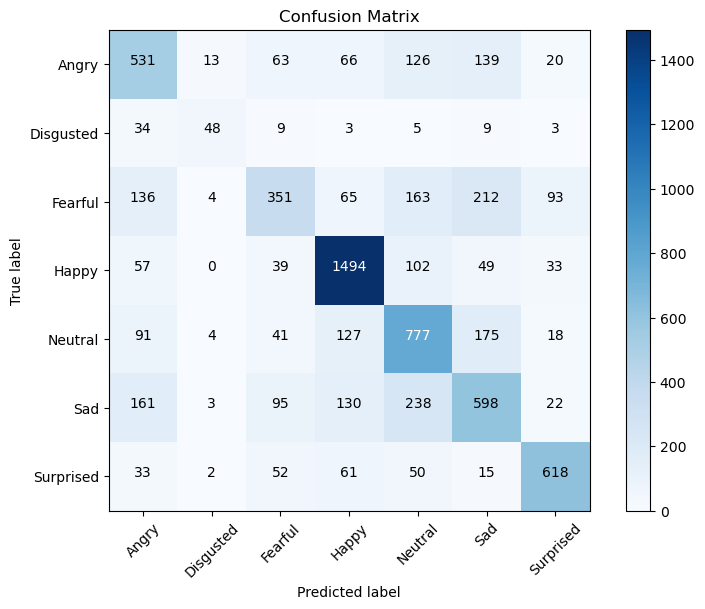

              precision    recall  f1-score   support

       Angry       0.51      0.55      0.53       958
   Disgusted       0.65      0.43      0.52       111
     Fearful       0.54      0.34      0.42      1024
       Happy       0.77      0.84      0.80      1774
     Neutral       0.53      0.63      0.58      1233
         Sad       0.50      0.48      0.49      1247
   Surprised       0.77      0.74      0.75       831

    accuracy                           0.62      7178
   macro avg       0.61      0.58      0.58      7178
weighted avg       0.61      0.62      0.61      7178



In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Define labels
labels = list(emotion_dict.values())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Annotate the plot with the values
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=labels))
